In [1]:
%pip install transformers 
%pip install sklearn
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments,DataCollatorWithPadding
from datasets import load_dataset, load_metric,Dataset
import torch
import numpy as np
from datasets import load_dataset
from utils import PrepareCorpus,AssessData
from sklearn.model_selection import train_test_split
from datasets import Dataset,load_dataset
import json
from re import template
from sklearn.model_selection import KFold

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
parentdir = "/content/drive/MyDrive/ML/Datasets/20News"

train =parentdir+"/20news-bydate"+"/20news-bydate-train"
test = parentdir+"/20news-bydate"+ "/20news-bydate-test"

In [5]:
id2labels = {'talk.politics.mideast': 0, 'rec.autos': 1, 'comp.sys.mac.hardware': 2, 'alt.atheism': 3, 'rec.sport.baseball': 4, 'comp.os.ms-windows.misc': 5, 'rec.sport.hockey': 6, 'sci.crypt': 7, 'sci.med': 8, 'talk.politics.misc': 9, 'rec.motorcycles': 10, 'comp.windows.x': 11, 'comp.graphics': 12, 'comp.sys.ibm.pc.hardware': 13, 'sci.electronics': 14, 'talk.politics.guns': 15, 'sci.space': 16, 'soc.religion.christian': 17, 'misc.forsale': 18, 'talk.religion.misc': 19}
#id2classes = {'talk.politics.mideast': 0, 'rec.autos': 4, 'comp.sys.mac.hardware': 2, 'alt.atheism': 5, 'rec.sport.baseball': 1, 'comp.os.ms-windows.misc': 2, 'rec.sport.hockey': 1, 'sci.crypt': 3, 'sci.med': 3, 'talk.politics.misc': 0, 'rec.motorcycles': 4, 'comp.windows.x': 2, 'comp.graphics': 2, 'comp.sys.ibm.pc.hardware': 2, 'sci.electronics': 3, 'talk.politics.guns': 0, 'sci.space': 3, 'soc.religion.christian': 5, 'misc.forsale': 6, 'talk.religion.misc': 5}

number = range(50,150,50)
_per_segment = range(200,400,100)
max_input_length = 300

f1_score = load_metric("f1"); precision = load_metric("precision"); recall = load_metric("recall")

def tokenize(batch):
    return bert_tokenizer(batch['text'], truncation=True, max_length=max_input_length,padding = True)

def compute_metrics(eval_pred):
    predictions, label = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return {"f1" :f1_score.compute(predictions = predictions, references = label, average = 'weighted'),
            "precision" : precision.compute(predictions = predictions, references = label, average = 'weighted'),
            "recall": recall.compute(predictions = predictions, references = label, average = 'weighted')}

def hp_space(trial):
  return {"per_device_train_batch_size": trial.suggest_discrete_uniform("per_device_train_batch_size", 8,32,8)
        ,"learning_rate": trial.suggest_float("learning_rate", 0.00001,0.00005, log = True)
        ,"num_train_epochs": trial.suggest_int("num_train_epochs",1,10)}

def bert_init():
  return BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 7)

def id_2_labels(x,adict):
  """converts labels/classes into a number using a dictionary"""
  return adict[x]

def _indexing(alist):
  id = 0; indexed = {}
  for x in alist:
    for y in x:
      id +=1
      indexed[id] = y
  return indexed
  

In [6]:
news_group_train = PrepareCorpus(train)
news_group_test = PrepareCorpus(test)

In [7]:
news_group_test = news_group_test._prep()       #Keys are labels, values are texts
news_group_train = news_group_train._prep()

In [8]:
#Full train and test data

train_list_of_strings = _indexing(news_group_train.values())
test_list_of_strings = _indexing(news_group_test.values())

train_corpus = AssessData(train_list_of_strings, news_group_train)
test_corpus = AssessData(test_list_of_strings, news_group_test)

In [9]:
train_index_to_label = train_corpus._index_to_label() 
test_index_to_label = test_corpus._index_to_label()

In [10]:
train_index_to_label

{0: 'talk.politics.guns',
 1: 'talk.politics.guns',
 2: 'talk.politics.guns',
 3: 'talk.politics.guns',
 4: 'talk.politics.guns',
 5: 'talk.politics.guns',
 6: 'talk.politics.guns',
 7: 'talk.politics.guns',
 8: 'talk.politics.guns',
 9: 'talk.politics.guns',
 10: 'talk.politics.guns',
 11: 'talk.politics.guns',
 12: 'talk.politics.guns',
 13: 'talk.politics.guns',
 14: 'talk.politics.guns',
 15: 'talk.politics.guns',
 16: 'talk.politics.guns',
 17: 'talk.politics.guns',
 18: 'talk.politics.guns',
 19: 'talk.politics.guns',
 20: 'talk.politics.guns',
 21: 'talk.politics.guns',
 22: 'talk.politics.guns',
 23: 'talk.politics.guns',
 24: 'talk.politics.guns',
 25: 'talk.politics.guns',
 26: 'talk.politics.guns',
 27: 'talk.politics.guns',
 28: 'talk.politics.guns',
 29: 'talk.politics.guns',
 30: 'talk.politics.guns',
 31: 'talk.politics.guns',
 32: 'talk.politics.guns',
 33: 'talk.politics.guns',
 34: 'talk.politics.guns',
 35: 'talk.politics.guns',
 36: 'talk.politics.guns',
 37: 'talk.

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
train_set = {"train" : {"text": train_list_of_strings.values(), "doc_id": train_list_of_strings.keys(), "labels": train_index_to_label.values()}}
test_set =  {"test" : {"text": test_list_of_strings.values(), 'doc_id': test_list_of_strings.keys(), 'labels': test_index_to_label.values()}}

In [13]:
#Convert to dataframe to change datatypes, then convert to dataset object
import pandas as pd

a = pd.DataFrame(train_set['train'])
b = pd.DataFrame(test_set['test'])

In [14]:
b

,text,doc_id,labels
0,From: Sang.Shin@launchpad.unc.edu (SANG SHIN)\...,1,rec.motorcycles
1,From: mrr3@po.CWRU.Edu (Mark R. Rabne)\n Subje...,2,rec.motorcycles
2,From: eerik@iastate.edu (Eerik J. Villberg)\n ...,3,rec.motorcycles
3,From: bgardner@pebbles.es.com (Blaine Gardner)...,4,rec.motorcycles
4,From: conboymj@leland.Stanford.EDU (Michael J ...,5,rec.motorcycles
...,...,...,...
7527,From: sepinwal@mail.sas.upenn.edu (Alan Sepinw...,7528,rec.sport.baseball
7528,From: talavage@sage.cc.purdue.edu (Tom Talavag...,7529,rec.sport.baseball
7529,From: sac@asdi.saic.com (Steve A. Conroy x6172...,7530,rec.sport.baseball
7530,From: baseball@catch-the-fever.scd.ucar.edu (G...,7531,rec.sport.baseball


In [15]:
#Maps 20 classes to 7 classes

a['labels'] = a['labels'].map(id2labels)
b['labels'] = b['labels'].map(id2labels)

In [16]:
set(a['labels']), set(b['labels'])

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19})

In [17]:
#Modify types

a['text'] = a['text'].astype(str)
a['doc_id'] = a['doc_id'].astype(int)
a['doc_id'] = a['doc_id'] -1
a['labels'] = a['labels'].astype(int)

b['text'] = b['text'].astype(str)
b['doc_id'] = b['doc_id'].astype(int)
b['doc_id'] = b['doc_id'] -1
b['labels'] = b['labels'].astype(int)

In [18]:
b

,text,doc_id,labels
0,From: Sang.Shin@launchpad.unc.edu (SANG SHIN)\...,0,10
1,From: mrr3@po.CWRU.Edu (Mark R. Rabne)\n Subje...,1,10
2,From: eerik@iastate.edu (Eerik J. Villberg)\n ...,2,10
3,From: bgardner@pebbles.es.com (Blaine Gardner)...,3,10
4,From: conboymj@leland.Stanford.EDU (Michael J ...,4,10
...,...,...,...
7527,From: sepinwal@mail.sas.upenn.edu (Alan Sepinw...,7527,4
7528,From: talavage@sage.cc.purdue.edu (Tom Talavag...,7528,4
7529,From: sac@asdi.saic.com (Steve A. Conroy x6172...,7529,4
7530,From: baseball@catch-the-fever.scd.ucar.edu (G...,7530,4


In [19]:
train = Dataset.from_pandas(a)
test = Dataset.from_pandas(b)

In [20]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train = train.map(tokenize)

  0%|          | 0/11314 [00:00<?, ?ex/s]

In [21]:
test = test.map(tokenize)

  0%|          | 0/7532 [00:00<?, ?ex/s]

In [22]:
train = train.shuffle(seed = 30)

In [23]:
from re import template
from sklearn.model_selection import KFold

fold = KFold(n_splits = 5)
this_set = fold.split(train['text'])

fold_train = []
fold_eval = []

for i,j in this_set:
  fold_train.append(train.select(i))
  fold_eval.append(train.select(j))

In [ ]:
training_args = TrainingArguments(output_dir="./results_temp", learning_rate=5e-5, per_device_train_batch_size=16, per_device_eval_batch_size=16, num_train_epochs=10,weight_decay=0.01)
results = []

data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, max_length= 300)
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 20, max_length = 300)

result = {}

#fine-tune

trainer = Trainer(model = bert_model, 
                args = training_args,
                train_dataset= fold_train[0],
                eval_dataset= fold_eval[0],
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
result = trainer.predict(test)

In [ ]:
result.metrics

In [ ]:
results_labels_300 = list(np.argmax(result.predictions, axis = 1))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test['labels'], results_labels_300)
f1 = f1_score.compute(predictions = results_labels_300, references = test["labels"], average = "weighted")
print(f1)

In [ ]:
correct = []; incorrect = []; incorrect_labels = []
orig_labels = test['labels']

for a,(b,c) in enumerate(zip(orig_labels, results_labels_300)):
    if b == c:
        correct.append(a)
    else:
        incorrect.append(a)
        incorrect_labels.append((b,c,))

len(incorrect)

MAXIMUM INPUT LENGTH OF 512

In [ ]:
training_args = TrainingArguments(output_dir="./results_temp", learning_rate=5e-5, per_device_train_batch_size=16, per_device_eval_batch_size=16, num_train_epochs=10,weight_decay=0.01)
results = []

data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, max_length= 512)
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 20, max_length = 512)

result = {}

#fine-tune

trainer_2 = Trainer(model = bert_model, 
                args = training_args,
                train_dataset= fold_train[0],
                eval_dataset= fold_eval[0],
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

trainer_2.train()

In [25]:
trainer_2.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, doc_id. If text, doc_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2263
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Step,Training Loss
500,1.092200
1000,0.386800
1500,0.219100
2000,0.124500
2500,0.067100
3000,0.043100
3019,0.043100


Trainer is attempting to log a value of "{'f1': 0.9181966867803933}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9198098682107921}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9182501104728237}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.48904183506965637,
 'eval_f1': {'f1': 0.9181966867803933},
 'eval_precision': {'precision': 0.9198098682107921},
 'eval_recall': {'recall': 0.9182501104728237}}

In [36]:
result = trainer_2.predict(test)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, doc_id. If text, doc_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 7532
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Step,Training Loss
500,1.092200
1000,0.386800
1500,0.219100
2000,0.124500
2500,0.067100
3000,0.043100
3019,0.043100


In [39]:
result_512 = list(np.argmax(result.predictions, axis = 1))

In [ ]:
result_512

{'f1': 0.8594979230700269}


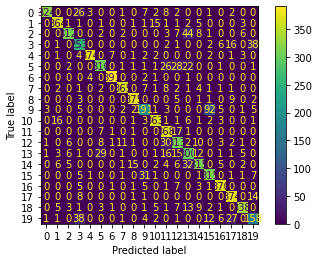

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test['labels'], result_512)
f1 = f1_score.compute(predictions = result_512, references = test["labels"], average = "weighted")
print(f1)

In [42]:
correct = []; incorrect = []; incorrect_labels = []
orig_labels = test['labels']

for a,(b,c) in enumerate(zip(orig_labels, result_512)):
    if b == c:
        correct.append(a)
    else:
        incorrect.append(a)
        incorrect_labels.append((b,c,))

len(incorrect)

1059